In [309]:
from atm_data.data_utils.weather_noaa_data import *
from pathlib import Path
from ast import literal_eval
import pandas as pd
import numpy as np
import functools

import matplotlib.pyplot as plt
from scipy.stats import pearsonr


In [285]:
data_dir = Path.cwd().resolve().parent / 'data'
weather_path = data_dir / 'noaa_lcdv2/lcd_lga_1987-2023_cleaned.parquet'
# TODO: handling in the bayesair remapped to like not have to do the "_decade" suffix
schedule_path = data_dir / 'bts_remapped/lga_reduced_2010-2019_clean_decade/parquet/lga_reduced_2010-2019_clean_decade.parquet'

# start_date = "2019-07-01"
# end_date = "2019-08-01" # exclusive

start_date = "2010-01-01"
end_date = "2020-01-01" # exclusive

wdf = pd.read_parquet(weather_path)
sdf = pd.read_parquet(schedule_path)
sdf = (
    sdf.set_index(
        pd.DatetimeIndex(sdf['date'])
    )
    .drop(['date'], axis=1)
)

wdf = wdf.loc[(wdf.index >= start_date) & (wdf.index < end_date)]
sdf = sdf.loc[(sdf.index >= start_date) & (sdf.index < end_date)]

for df in (wdf, sdf):
    display(df)
    display(df.dtypes)


,hourly_alitmeter_setting,hourly_dew_point_temperature,hourly_dry_bulb_temperature,hourly_precipitation,hourly_relative_humidity,hourly_visibility,hourly_wind_direction,hourly_wind_speed,hourly_wind_gust_speed,hpwt_BCFG,...,hsc_layer_1_height,hsc_layer_2_height,hsc_layer_3_height,hsc_total_coverage,hsc_total_amount,hsc_total_height,hsc_ceiling_coverage,hsc_ceiling_amount,hsc_ceiling_height,hourly_sky_conditions
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1015.2,-0.6,0.6,0.3,92.0,4.023,60.0,1.5,0.0,False,...,1.52,4.27,NaN,OVC,8.0,4.27,OVC,8.0,4.27,SCT:04-1.52 OVC:08-4.27
2010-01-01 01:00:00,1015.2,0.0,1.1,0.0,92.0,4.023,60.0,0.0,0.0,False,...,1.83,4.27,NaN,OVC,8.0,4.27,BKN,7.0,1.83,BKN:07-1.83 OVC:08-4.27
2010-01-01 02:00:00,1014.9,0.0,1.1,0.0,92.0,4.828,80.0,1.5,0.0,False,...,1.83,NaN,NaN,OVC,8.0,1.83,OVC,8.0,1.83,OVC:08-1.83
2010-01-01 03:00:00,1014.6,0.0,0.6,0.0,96.0,8.047,90.0,0.0,0.0,False,...,1.83,NaN,NaN,OVC,8.0,1.83,OVC,8.0,1.83,OVC:08-1.83
2010-01-01 04:00:00,1014.2,0.0,0.6,0.0,96.0,8.047,100.0,1.5,0.0,False,...,1.83,NaN,NaN,OVC,8.0,1.83,OVC,8.0,1.83,OVC:08-1.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,1003.0,1.7,7.2,0.0,68.0,16.093,210.0,4.6,0.0,False,...,15.24,18.29,NaN,OVC,8.0,18.29,BKN,7.0,15.24,BKN:07-15.24 OVC:08-18.29
2019-12-31 20:00:00,1004.1,1.1,6.7,0.3,68.0,16.093,280.0,7.2,12.4,False,...,8.23,10.06,14.94,OVC,8.0,14.94,OVC,8.0,14.94,FEW:02-8.23 SCT:04-10.06 OVC:08-14.94
2019-12-31 21:00:00,1003.7,0.0,6.1,0.0,65.0,16.093,270.0,6.2,10.8,False,...,8.23,16.76,NaN,OVC,8.0,16.76,OVC,8.0,16.76,FEW:02-8.23 OVC:08-16.76


hourly_alitmeter_setting         float64
hourly_dew_point_temperature     float64
hourly_dry_bulb_temperature      float64
hourly_precipitation             float64
hourly_relative_humidity         float64
hourly_visibility                float64
hourly_wind_direction            float64
hourly_wind_speed                float64
hourly_wind_gust_speed           float64
hpwt_BCFG                        boolean
hpwt_BL                          boolean
hpwt_BLSN                        boolean
hpwt_BR                          boolean
hpwt_DRSN                        boolean
hpwt_DZ                          boolean
hpwt_FG                          boolean
hpwt_FU                          boolean
hpwt_FZDZ                        boolean
hpwt_FZFG                        boolean
hpwt_FZRA                        boolean
hpwt_GR                          boolean
hpwt_GS                          boolean
hpwt_HAIL                        boolean
hpwt_HZ                          boolean
hpwt_MIFG       

,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure_time,scheduled_arrival_time,actual_departure_time,actual_arrival_time,wheels_off_time,wheels_on_time,...,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,cancelled,cancellation_code,diverted,diverted_reached_destination,diverted_airport_landings
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,AA:705,N4XPAA,LGA,DFW,6.000000,10.083333,5.916667,9.833333,6.183333,9.750000,...,0.00,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0
2010-01-01,AA:2257,N5DCAA,LGA,MIA,6.000000,9.166667,6.100000,9.433333,6.533333,9.316667,...,0.00,0.1,0.166667,0.0,0.0,False,Z,False,<NA>,0
2010-01-01,B6:371,N661JB,LGA,FLL,6.000000,8.950000,6.050000,9.650000,6.766667,9.566667,...,0.05,0.0,0.650000,0.0,0.0,False,Z,False,<NA>,0
2010-01-01,DL:1769,N676DL,LGA,ATL,6.000000,8.733333,6.000000,8.616667,6.283333,8.466667,...,0.00,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0
2010-01-01,FL:359,N338AT,LGA,ATL,6.000000,8.600000,5.950000,8.900000,6.433333,8.750000,...,0.00,0.0,0.300000,0.0,0.0,False,Z,False,<NA>,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,B6:1332,N328JB,LGA,BOS,21.500000,22.683333,21.200000,22.250000,21.400000,22.100000,...,0.00,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0
2019-12-31,DL:2814,N321DH,ATL,LGA,21.500000,23.633333,21.466667,23.350000,21.650000,23.233333,...,0.00,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0
2019-12-31,B6:1431,N198JB,BOS,LGA,21.500000,22.783333,21.616667,22.516667,21.850000,22.483333,...,0.00,0.0,0.000000,0.0,0.0,False,Z,False,<NA>,0


flight_number                   string[python]
tail_number                     string[python]
origin_airport                  string[python]
destination_airport             string[python]
scheduled_departure_time               float64
scheduled_arrival_time                 float64
actual_departure_time                  float64
actual_arrival_time                    float64
wheels_off_time                        float64
wheels_on_time                         float64
departure_delay                        float64
arrival_delay                          float64
carrier_delay                          float64
weather_delay                          float64
nas_delay                              float64
security_delay                         float64
late_aircraft_delay                    float64
cancelled                              boolean
cancellation_code                     category
diverted                               boolean
diverted_reached_destination           boolean
diverted_airp

In [286]:
# TODO: some stats

In [306]:
def plot_condition_and_delays(
    type, 
    # these should be aligned time-wise
    conditions,
    dep_delays,
    arr_delays,
    start,
    end,
    condition_aggregation,
    delay_aggregation,
    figsize = (12,8)
):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()

    ax.plot(conditions, color='blue', label=f'{type}')
    ax2.plot(dep_delays, color='red', label='departure delay')
    ax2.plot(arr_delays, color='orange', label='arrival delay')

    ax.set_ylabel(
        f"{type} {'(ft)' if type == 'ceiling' else '(mi)'} -- lower is worse -- [{condition_aggregation}]"
    )
    ax2.set_ylabel(f'delay (hrs) -- higher is worse -- [{delay_aggregation}]')
    ax.set_xlabel('date')

    ax.set_title(
        f'{type} and delays between {start} and {end}'
    )
    ax.set_ylim(bottom=0)
    # ax2.set_ylim(bottom=-.05)

    add_flight_rule_regions(ax, type, 'horizontal')
    fig.legend()

    return fig

def add_flight_rule_regions(
    ax, 
    type,
    side, 
    thresholds=None,
    colors=None,
    alpha=.2,
    linestyle='--',
):
    if side == 'horizontal':
        add_line = ax.axhline
        add_span = ax.axhspan            
    elif side == 'vertical':
        add_line = ax.axvline
        add_span = ax.axvspan
    else:
        raise ValueError('type must be horizontal or vertical :(')

    if thresholds is None:
        if type == 'ceiling':
            thresholds = [500, 1000, 3200]
        elif type == 'visibility':
            thresholds = [1, 3, 4]
        else:
            raise ValueError('type must be ceiling or visibility')
    else:
        assert len(thresholds) == 3 # TODO: generalize??
        
    if colors is None:
        colors = ['darkred', 'red', 'yellow', 'lightgreen']
    else:
        assert len(colors) == 4 # TODO: generalize??

    for threshold, color in zip(thresholds, colors):
        add_line(threshold, color=color, linestyle=linestyle)
    
    span_lo = [0] + thresholds
    span_hi = thresholds + [ax.get_ylim()[1]]

    labels = [
        'LIFR (low IFR)',
        'IFR (instrument)',
        'MVFR (marginal)',
        'VFR (visual)',
    ]
    
    for lo, hi, color, label in zip(span_lo, span_hi, colors, labels):
        add_span(lo, hi, facecolor=color, alpha=alpha, label=label)



('no_inf', 'no_nan', ('mean', '1D'))
no_inf <class 'str'>
no_nan <class 'str'>
('mean', '1D') <class 'tuple'>
('min',)
min <class 'str'>
('inverse', ('mean', '1D'))
inverse <class 'str'>
('mean', '1D') <class 'tuple'>
('inverse',)
inverse <class 'str'>
(('clip', 0.5, 64),)
('clip', 0.5, 64) <class 'tuple'>
(('mean', '1D'),)
('mean', '1D') <class 'tuple'>
('inverse', ('mean', '1D'))
inverse <class 'str'>
('mean', '1D') <class 'tuple'>
('inverse',)
inverse <class 'str'>
(('mean', '1D'),)
('mean', '1D') <class 'tuple'>
(('mean', '1D'),)
('mean', '1D') <class 'tuple'>
(('scale', 100), ('clip_index', '2019-07-01', '2019-08-01'))
('scale', 100) <class 'tuple'>
('clip_index', '2019-07-01', '2019-08-01') <class 'tuple'>
(('clip_index', '2019-07-01', '2019-08-01'),)
('clip_index', '2019-07-01', '2019-08-01') <class 'tuple'>
(('clip_index', '2019-07-01', '2019-08-01'),)
('clip_index', '2019-07-01', '2019-08-01') <class 'tuple'>


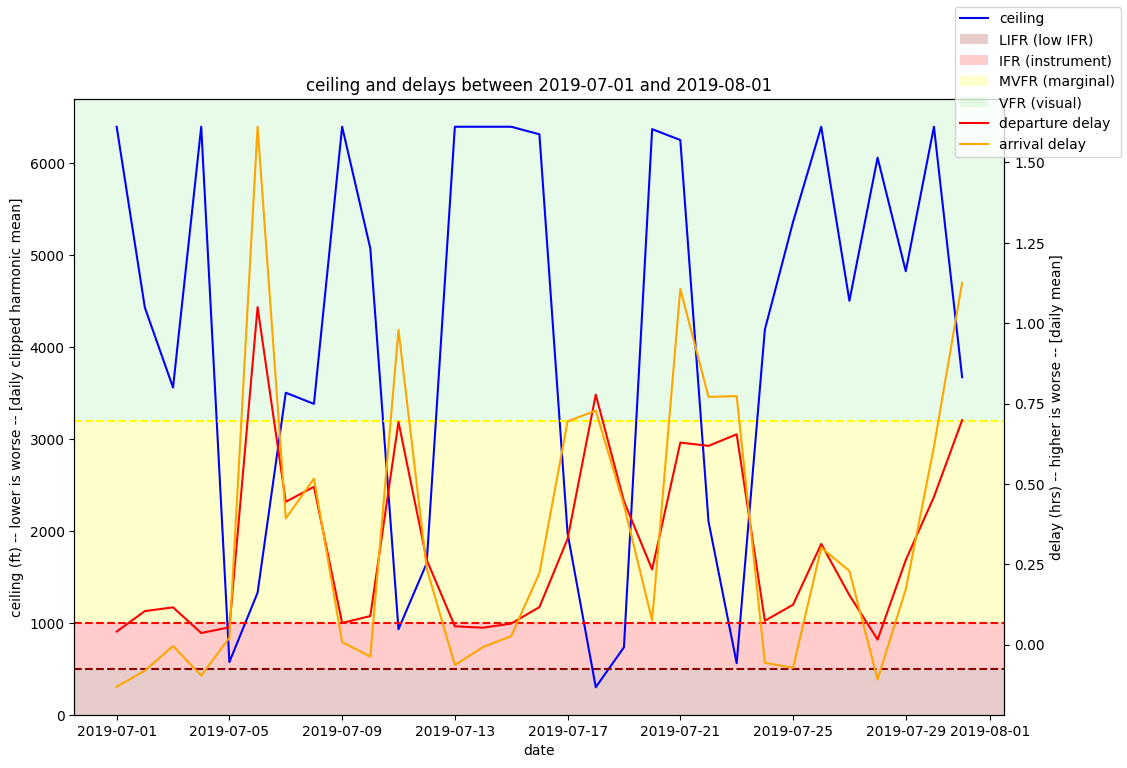

In [332]:
def process_series(
    s,
    *argv,
):
    # print(argv)
    for arg in argv:
        # print(arg, type(arg))
        if isinstance(arg, str):
            action = arg
            if action == 'no_inf':
                s = s.loc[~s.isin([np.inf])]
            elif action == 'no_nan':
                s = s.loc[~s.isin([np.nan])]
            elif action == 'inverse':
                s = 1.0 / s
        elif isinstance(arg, (list, tuple, np.ndarray)):
            action = arg[0]
            if action == 'scale':
                s = s * arg[1]
            elif action == 'clip':
                s = s.clip(lower=arg[1], upper=arg[2])
            elif action == 'clip_index':
                s = s.loc[(arg[1] <= s.index) & (s.index < arg[2])]
            elif action == 'apply_func':
                s = s.apply(arg[1])
            elif action == 'apply_func_vec':
                s = arg[1](s)
            else:
                sg = s.groupby(pd.Grouper(freq=arg[1]))
                if action == 'mean':
                    s = sg.mean()
                elif action == 'min':
                    s = sg.min()
                elif action == 'max':
                    s = sg.max()
                else:
                    raise ValueError(f'invalid step: {arg}')
    return s

freq = '1D'
ceiling = wdf.hsc_ceiling_height

process_ceiling = functools.partial(process_series, ceiling)

ch_daily_finite_mean = process_ceiling(
    'no_inf', 'no_nan', ('mean', freq)
)

ch_daily_min = process_ceiling(
    'min'
)

ch_daily_inverse_mean = process_ceiling(
    'inverse', ('mean', freq)
)
ch_daily_harmonic_mean = process_series(
    ch_daily_inverse_mean, 'inverse'
)

ch_hourly_clipped = process_ceiling(
    ('clip', .5, 64)
)

ch_daily_clipped_mean = process_series(
    ch_hourly_clipped, ('mean', freq)
)

ch_daily_clipped_inverse_mean = process_series(
    ch_hourly_clipped, ('inverse'), ('mean', freq)  
)

ch_daily_clipped_harmonic_mean = process_series(
    ch_daily_clipped_inverse_mean, ('inverse')
)

# display(ch_daily_clipped_harmonic_mean.nsmallest(5))

sdf_outgoing = sdf.loc[sdf.origin_airport == 'LGA']
sdf_incoming = sdf.loc[sdf.destination_airport == 'LGA']

dep_delay_daily = process_series(
    sdf_outgoing.departure_delay, ('mean', freq)
)
arr_delay_daily = process_series(
    sdf_incoming.arrival_delay, ('mean', freq)
)

start = '2019-07-01'
end = '2019-08-01'
v = process_series(
    ch_daily_clipped_harmonic_mean, 
    ('scale', 100), ('clip_index', start, end)
)

d = process_series(
    dep_delay_daily, ('clip_index', start, end)
)

a = process_series(
    arr_delay_daily, ('clip_index', start, end)
)

fig = plot_condition_and_delays(
    type='ceiling', 
    conditions=v,
    dep_delays=d,
    arr_delays=a,
    start=start,
    end=end,
    condition_aggregation='daily clipped harmonic mean',
    delay_aggregation='daily mean',
)

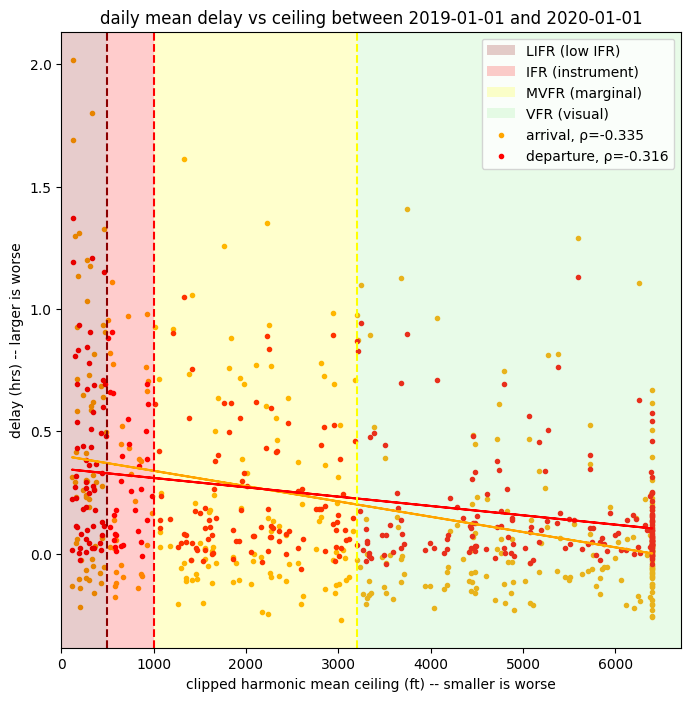

In [280]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

def plot_scatter_and_trend(ax, x, y, color, linestyle='-', marker='.', label=None, d=1):        
    ax.scatter(x, y, color=c, marker=marker, label=label)
    z = np.polyfit(x, y, deg=d)
    p = np.poly1d(z)
    plt.plot(x, p(x), color=color, linestyle=linestyle)

# x = v
# for y, c, l in ((a, 'orange', 'arrival'), (d, 'red', 'departure')):
x = 100 * ch_daily_clipped_harmonic_mean
for y, c, l in ((arr_delay_daily, 'orange', 'arrival'), (dep_delay_daily, 'red', 'departure')):
    r, _ = pearsonr(x, y)
    plot_scatter_and_trend(ax, x.to_numpy(), y.to_numpy(), c, label=f'{l}, ρ={r:.03f}')

ax.set_xlim(left=0)

ax.axvline(500, color='darkred', linestyle='--')
ax.axvline(1000, color='red', linestyle='--')
ax.axvline(3200, color='yellow', linestyle='--')

alpha = .2
ax.axvspan(0, 500, facecolor='darkred', alpha=alpha, label='LIFR (low IFR)')
ax.axvspan(500, 1000, facecolor='red', alpha=alpha, label='IFR (instrument)')
ax.axvspan(1000, 3200, facecolor='yellow', alpha=alpha, label='MVFR (marginal)')
ax.axvspan(3200, ax.get_xlim()[1], facecolor='lightgreen', alpha=alpha, label='VFR (visual)')

ax.set_xlabel('clipped harmonic mean ceiling (ft) -- smaller is worse')
ax.set_ylabel('delay (hrs) -- larger is worse')
ax.set_title(f'daily mean delay vs ceiling between {start_date} and {end_date}')

ax.legend()

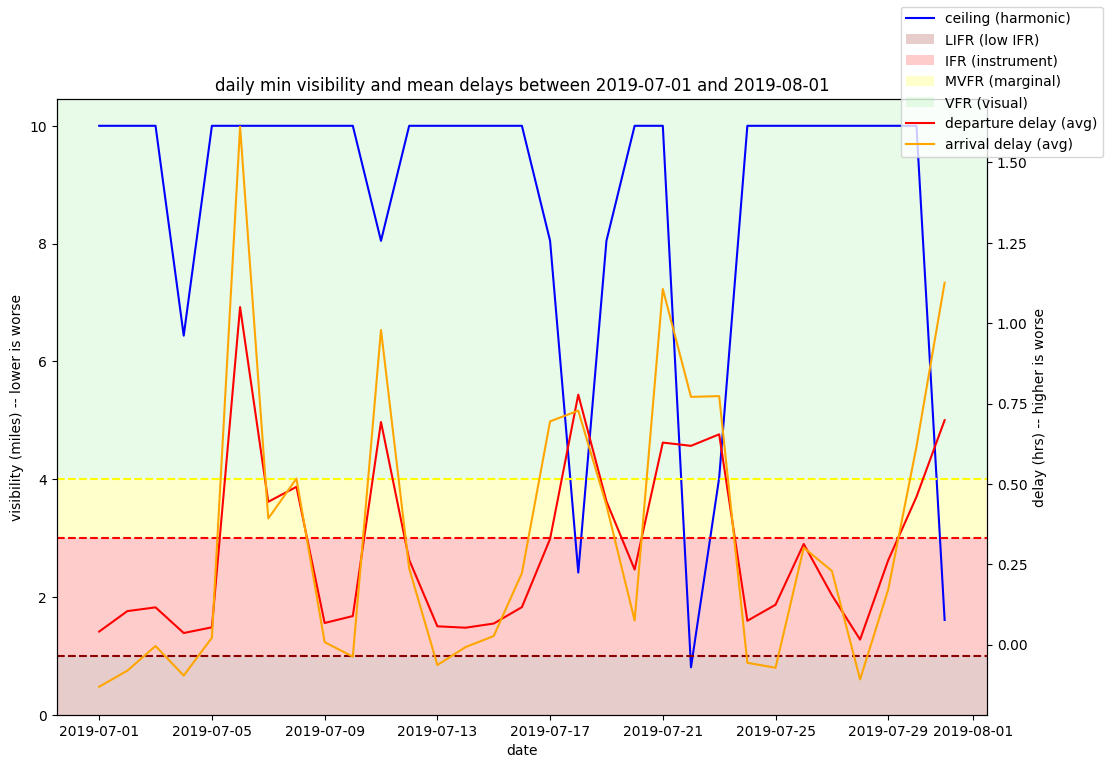

In [281]:
# TODO: make a function and not just have this copied lol

ch_hourly_clipped = wdf.hourly_visibility.clip(lower=.001, upper=10)

ch_daily_clipped_mean = (
    ch_hourly_clipped
    .groupby(pd.Grouper(freq=freq))
    .mean()
)
ch_daily_clipped_inverse_mean = (
    (1.0 / ch_hourly_clipped)    
    .groupby(pd.Grouper(freq=freq))
    .mean()
)
ch_daily_clipped_harmonic_mean = (
    1.0 / ch_daily_clipped_inverse_mean
)

ch_daily_clipped_harmonic_mean = (ch_hourly_clipped.groupby(pd.Grouper(freq=freq)).min())

# display(ch_daily_clipped_harmonic_mean.nsmallest(5))

sdf_outgoing = sdf.loc[sdf.origin_airport == 'LGA']
sdf_incoming = sdf.loc[sdf.destination_airport == 'LGA']

dep_delay_daily = sdf_outgoing.departure_delay.groupby(pd.Grouper(freq=freq)).mean()
arr_delay_daily = sdf_incoming.arrival_delay.groupby(pd.Grouper(freq=freq)).mean()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

start = '2019-07-01'
end = '2019-08-01'
v = ch_daily_clipped_harmonic_mean.loc[
    (start <= ch_daily_clipped_harmonic_mean.index) 
    & (ch_daily_clipped_harmonic_mean.index < end)
]
d = dep_delay_daily.loc[
    (start <= dep_delay_daily.index)
    & (dep_delay_daily.index < end)
]
a = arr_delay_daily.loc[
    (start <= arr_delay_daily.index)
     & (arr_delay_daily.index < end)
]

ax2 = ax.twinx()
# plt.plot(ch_daily_clipped_mean, label='straight')
ax.plot(v, color='blue', label='ceiling (harmonic)')
ax2.plot(d, color='red', label='departure delay (avg)')
ax2.plot(a, color='orange', label='arrival delay (avg)')

ax.set_ylabel('visibility (miles) -- lower is worse')
ax2.set_ylabel('delay (hrs) -- higher is worse')
ax.set_xlabel('date')
ax.set_title(f'daily min visibility and mean delays between {start} and {end}')

# ax.set_ylim(top=6400)
ax.set_ylim(bottom=0)
# ax2.set_ylim(bottom=-.05)

ax.axhline(1, color='darkred', linestyle='--')
ax.axhline(3, color='red', linestyle='--')
ax.axhline(4, color='yellow', linestyle='--')

alpha = .2
ax.axhspan(0, 1, facecolor='darkred', alpha=alpha, label='LIFR (low IFR)')
ax.axhspan(1, 3, facecolor='red', alpha=alpha, label='IFR (instrument)')
ax.axhspan(3, 4, facecolor='yellow', alpha=alpha, label='MVFR (marginal)')
ax.axhspan(4, ax.get_ylim()[1], facecolor='lightgreen', alpha=alpha, label='VFR (visual)')

# ax.legend()
# ax2.legend()
fig.legend()




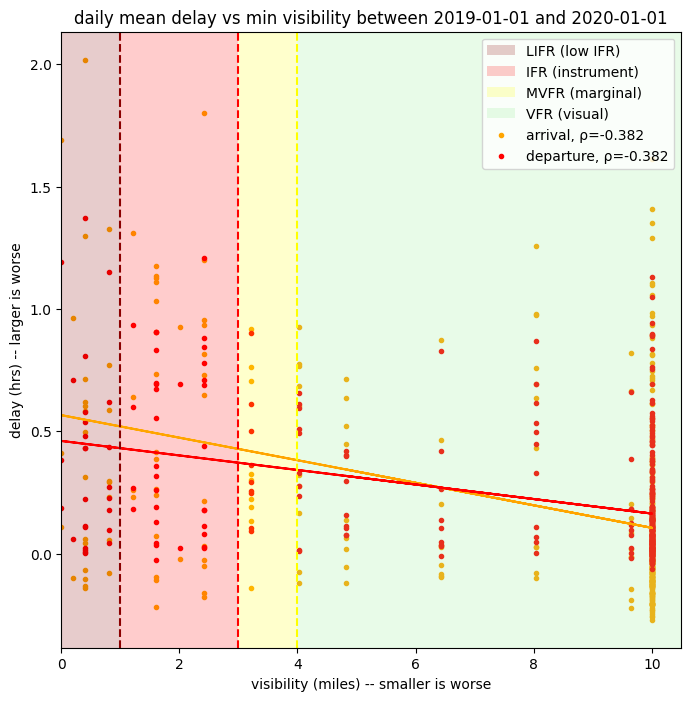

In [282]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

def plot_scatter_and_trend(ax, x, y, color, linestyle='-', marker='.', label=None, d=1):        
    ax.scatter(x, y, color=c, marker=marker, label=label)
    z = np.polyfit(x, y, deg=d)
    p = np.poly1d(z)
    plt.plot(x, p(x), color=color, linestyle=linestyle)

# x = v
# for y, c, l in ((a, 'orange', 'arrival'), (d, 'red', 'departure')):
x = ch_daily_clipped_harmonic_mean
for y, c, l in ((arr_delay_daily, 'orange', 'arrival'), (dep_delay_daily, 'red', 'departure')):
    r, _ = pearsonr(x, y)
    plot_scatter_and_trend(ax, x.to_numpy(), y.to_numpy(), c, label=f'{l}, ρ={r:.03f}')

ax.set_xlim(left=0)

ax.axvline(1, color='darkred', linestyle='--')
ax.axvline(3, color='red', linestyle='--')
ax.axvline(4, color='yellow', linestyle='--')

alpha = .2
ax.axvspan(0, 1, facecolor='darkred', alpha=alpha, label='LIFR (low IFR)')
ax.axvspan(1, 3, facecolor='red', alpha=alpha, label='IFR (instrument)')
ax.axvspan(3, 4, facecolor='yellow', alpha=alpha, label='MVFR (marginal)')
ax.axvspan(4, ax.get_xlim()[1], facecolor='lightgreen', alpha=alpha, label='VFR (visual)')

ax.set_xlabel('visibility (miles) -- smaller is worse')
ax.set_ylabel('delay (hrs) -- larger is worse')
ax.set_title(f'daily mean delay vs min visibility between {start_date} and {end_date}')

ax.legend()